In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
test_transaction = pd.read_csv('test_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

calculating on which transaction happened

In [3]:
test_transaction['day'] = np.ceil(test_transaction.TransactionDT / 86400)
train_transaction['day'] = np.ceil(train_transaction.TransactionDT / 86400)

average amount spent per day by card1

In [4]:
avg_amt_day = test_transaction[['day', 'card1', 'TransactionAmt']].groupby(by=['day', 'card1'])['TransactionAmt'].mean().reset_index()
test_transaction['avg_amt_day'] = avg_amt_day['TransactionAmt']

avg_amt_day = train_transaction[['day', 'card1', 'TransactionAmt']].groupby(by=['day', 'card1'])['TransactionAmt'].mean().reset_index()
train_transaction['avg_amt_day'] = avg_amt_day['TransactionAmt']
del avg_amt_day

average amount spent totally by **card1**

In [5]:
avg_amt_spent = train_transaction[['card1', 'TransactionAmt']].groupby(['card1']).sum()
avg_amt_spent = avg_amt_spent.rename(columns={'TransactionAmt':'avg_amt_spent'})
train_transaction = train_transaction.merge(avg_amt_spent, on='card1', how='left').reset_index()

avg_amt_spent = test_transaction[['card1', 'TransactionAmt']].groupby(['card1']).sum()
avg_amt_spent = avg_amt_spent.rename(columns={'TransactionAmt':'avg_amt_spent'})
test_transaction = test_transaction.merge(avg_amt_spent, on='card1', how='left').reset_index()
del avg_amt_spent

std amount spent totally by card1

In [6]:
std_amt_spent = train_transaction[['card1', 'TransactionAmt']].groupby(['card1']).std()
std_amt_spent = std_amt_spent.rename(columns={'TransactionAmt':'std_amt_spent'})
train_transaction = train_transaction.merge(std_amt_spent, on='card1', how='left').reset_index()

In [7]:
std_amt_spent = test_transaction[['card1', 'TransactionAmt']].groupby(['card1']).std()
std_amt_spent = std_amt_spent.rename(columns={'TransactionAmt':'std_amt_spent'})
test_transaction = test_transaction.merge(std_amt_spent, on='card1', how='left').reset_index()
del std_amt_spent

average amount spent on **card1** by using card type **card6**

In [8]:
avg_amt_card_type = test_transaction[['card6', 'card1', 'TransactionAmt']].groupby(by=['card6', 'card1'])['TransactionAmt'].mean().reset_index()
test_transaction['avg_amt_card_type'] = avg_amt_card_type['TransactionAmt']

avg_amt_card_type = train_transaction[['card6', 'card1', 'TransactionAmt']].groupby(by=['card6', 'card1'])['TransactionAmt'].mean().reset_index()
train_transaction['avg_amt_card_type'] = avg_amt_card_type['TransactionAmt']
del avg_amt_card_type

number of times card used today until current transaction using **card1**

In [9]:
train_transaction['card_used'] = 1
train_transaction['card_used_till_now_today'] = train_transaction[['card1', 'day','card_used']].groupby(['card1', 'day'])['card_used'].apply(lambda x: x.cumsum())

In [10]:
del train_transaction['card_used']

test_transaction['card_used'] = 1
test_transaction['card_used_till_now_today'] = test_transaction[['card1', 'day','card_used']].groupby(['card1', 'day'])['card_used'].apply(lambda x: x.cumsum())
del test_transaction['card_used']

In [3]:
# train = pd.merge(train_transaction,train_identity,on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# print('train dataset shape', train.shape)
print('test dataset shape', test.shape)

test dataset shape (506691, 433)


In [5]:
test[:30].to_csv('test.csv', columns=test.columns)

In [12]:
del train_identity, train_transaction, test_identity, test_transaction

In [13]:
train.to_pickle('train.pkl')
test.to_pickle('test.pkl')

# loading already preprocessed data

In [64]:
import pickle

file = open('train.pkl', 'rb')
train = pickle.load(file)
file = open('test.pkl', 'rb')
test =  pickle.load(file)

In [3]:
train.head()

,level_0,index,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,0,2987000,0,86400,68.5,W,13926,NaN,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2987001,0,86401,29.0,W,2755,404.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2987002,0,86469,59.0,W,4663,490.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2987003,0,86499,50.0,W,18132,567.0,150.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2987004,0,86506,50.0,H,4497,514.0,150.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


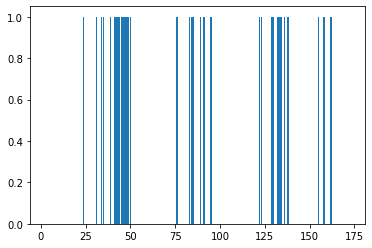

In [57]:
plt.bar(train['id_31'][:50000],y_train[:50000],align='center')
plt.show()

In [59]:
X_train['id_31'].head()

0    136
1    136
2    136
3    136
4    162
Name: id_31, dtype: int64

In [4]:
test.head()

,level_0,index,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,0,0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


categorical columns: id_12 - id_38
numerical columns: id_01 - id_11

/home/divyay/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/divyay/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


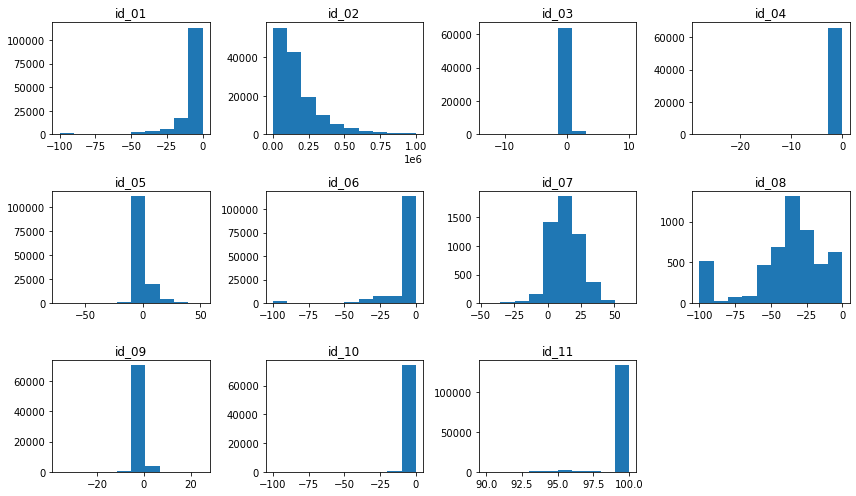

In [5]:
fig = plt.figure(figsize=(12,7))
p = 0
for i in range(1, 12):
  c=''
  if i<10:
    c = '0'
  col = 'id_' + c + str(i)
  p+=1; fig.add_subplot(3, 4, p)
  fig.tight_layout()
  plt.hist(train[col])
  plt.title(col)
plt.show()

looks like id_03, id_05, id_07, id_09 are already normalized

train['V1'].dtype

all Vesta columns (V1 - V339) are boolean values

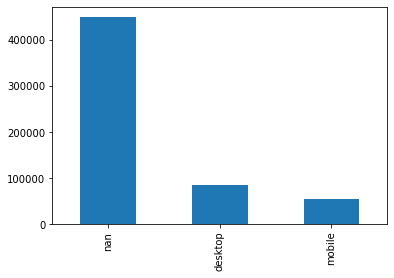

In [29]:
train.groupby([]).DeviceType.value_counts(dropna=False).plot(kind='bar')
# train.DeviceInfo.isnull().sum()

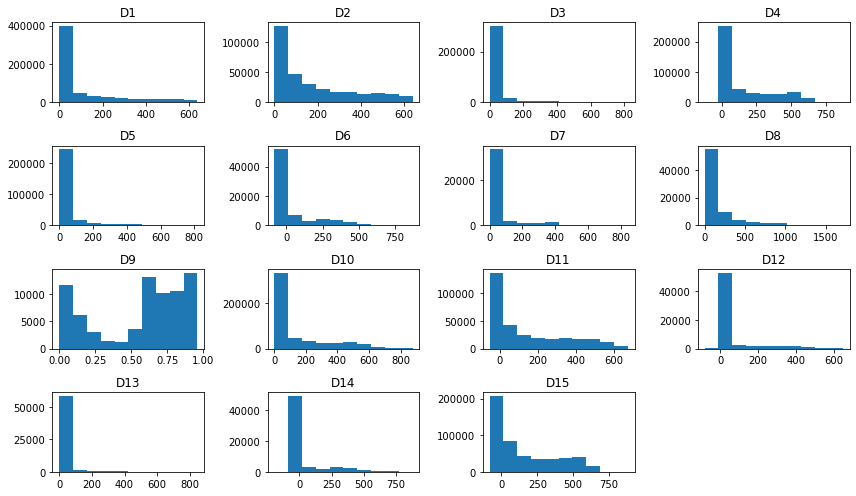

In [30]:
fig = plt.figure(figsize=(12,7))
p = 0
for i in range(1, 16):
  col = 'D' + str(i)
  p+=1; fig.add_subplot(4, 4, p)
  fig.tight_layout()
  plt.hist(train[col])
  plt.title(col)
plt.show()

In [31]:
train.card6.value_counts(dropna=False)

debit              439938
credit             148986
NaN                  1571
debit or credit        30
charge card            15
Name: card6, dtype: int64

In [65]:
cols_to_rename = []
cols_values = []
for i in range(1, 39):
  c=''
  if i<10:
    c='0'
  cols_to_rename += ['id-'+ c + str(i)]
  cols_values += ['id_'+ c + str(i)]
test = test.rename(columns=dict(zip(cols_to_rename, cols_values)))

In [66]:
cols_lotof_nulls = [c for c in train.columns if (train[c].isnull().sum() / train.shape[0])>0.9]
cols_lotof_nulls_test = [c for c in test.columns if (test[c].isnull().sum() / test.shape[0])>0.9]

In [67]:
cols_with_single_values = [c for c in train.columns if (train[c].nunique() == 1)]
cols_with_single_values_test = [c for c in test.columns if (test[c].nunique() == 1)]

In [68]:
cols_to_drop = list(set(cols_lotof_nulls+ cols_lotof_nulls_test+ cols_with_single_values+ cols_with_single_values_test))
# cols_to_drop.remove('isFraud')
len(cols_to_drop)

14

In [69]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [70]:
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)


In [71]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
            'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
            'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 
            'id_33', 'id_34', 'id_35', 'id_36', 'id_37','id_38', 'DeviceType', 
            'DeviceInfo', 'ProductCD','P_emaildomain','R_emaildomain',
            'M1','M2','M3','M4','M5','M6','M7','M8', 'M9', 'P_emaildomain_1', 
            'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 
            'R_emaildomain_3', 'card4', 'card3', 'card2', 'card1', 'card5', 'card6']

In [72]:
for col in cat_cols:
  if col in train.columns:
    le = LabelEncoder()
    le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
    train[col] = le.transform(list(train[col].astype('str').values))
    test[col] = le.transform(list(test[col].astype('str').values))

In [73]:
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

In [74]:
# train.fillna(-1)
# test.fillna(-1)

In [75]:
X_train = train.sort_values('TransactionDT').drop(['TransactionID', 'isFraud', 'TransactionDT','level_0','index','day'], axis=1)
y_train = train.sort_values('TransactionDT')['isFraud']

In [78]:
X_test = test.drop(['TransactionDT', 'TransactionID','index','day','level_0'], axis=1)
del train
test = test[["TransactionDT", 'TransactionID']]

In [80]:
print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_test shape', X_test.shape)

X_train shape (590540, 428)
y_train shape (590540,)
X_test shape (506691, 428)


In [81]:
num_values = {}
for c in X_train.columns:
    vals = X_train[c].nunique()
    if vals < 5:
        num_values[c] = vals
# num_values

In [82]:
num_values_test = {}
for c in X_test.columns:
    vals = X_test[c].nunique()
    if vals < 5:
        num_values_test[c] = vals

In [83]:
num_values_test == num_values

True

In [84]:
from sklearn.preprocessing import OneHotEncoder
def get_dummies(X, cols):
    for c in cols:
        enc = OneHotEncoder(handle_unknown='ignore')
        X[c] = X[c].fillna(-1)
        enc_df = pd.DataFrame(enc.fit_transform(X[[c]]).toarray())
        enc_df.columns = enc.get_feature_names([c])
        X.drop(c, inplace=True, axis=1)
        X = X.join(enc_df)
    return X

In [85]:
X_train = get_dummies(X_train, num_values)
X_test = get_dummies(X_test, num_values)

In [91]:
in_train = list(set(X_train.columns) - set(X_test.columns))

In [90]:
in_test = list(set(X_test.columns) - set(X_train.columns))

In [94]:
in_test[2] in X_test

True

In [95]:
test_extra = X_test[in_test]
train_extra = X_train[in_train]
X_test = X_test.drop(in_test, axis=1)
X_train = X_train.drop(in_train, axis=1)

In [96]:
len(X_test.columns) == len(X_train.columns), (X_test.columns == X_train.columns).all()

(True, True)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

n_fold=3
folds = TimeSeriesSplit(n_splits=n_fold)


In [97]:
import gc
gc.collect()

293

In [128]:
cols_less_imp = ['V120_1.0', 'V118_1.0', 'V89_0.0', 'V27_0.0', 'V113', 'M2_2', 'V28_0.0', 'id_15_3',
 'id_28_2', 'V117_2.0', 'V14_-1.0', 'V88_0.0', 'V14_0.0', 'V27_2.0',
 'V27_4.0', 'V28_-1.0', 'V27_-1.0', 'V27_1.0', 'V89_-1.0', 'V12_3.0', 'V1_0.0', 'V305_1.0',
 'M3_2', 'id_29_2', 'M1_0', 'id_35_2', 'V241', 'id_36_2',
 'id_37_2', 'id_38_2', 'V305_2.0', 'V122_0.0', 'V305_-1.0', 'V35_3.0', 'V89_1.0', 'V68_2.0', 'V68_1.0', 'V89_2.0',
 'V94_-1.0', 'V65_0.0', 'V94_2.0', 'V117_0.0', 'V41_0.0', 'V118_0.0', 'V118_3.0', 'V122_3.0', 'V119_0.0',
 'V119_1.0', 'V119_2.0', 'V120_0.0', 'V120_3.0',
 'V121_0.0', 'V28_4.0', 'V28_2.0', 'V121_3.0', 'V28_1.0', 'DeviceType_2']
X_train = X_train.drop(cols_less_imp, axis= 1)
X_test = X_test.drop(cols_less_imp, axis=1)

In [46]:
top_10 = ['TransactionAmt',
 'addr1',
 'card1',
 'std_amt_spent',
 'avg_amt_spent',
 'card_used_till_now_today',
 'card2',
 'avg_amt_day',
 'dist1',
 'id_02']
X_train_10 = X_train[top_10]
X_test_10 = X_test[top_10]

In [129]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
clf = lgb.LGBMClassifier(max_depth=12,
                        feature_fraction=0.9,
                        bagging_fraction=0.9,
                        early_stopping_round=200,
                        reg_lambda=0.3,
                        application='binary',
                        num_boost_round=6000,
                        learning_rate=0.1,
                        num_leaves=240,
                        metric='binary_logloss',
                        eval_metric  = 'auc',
                        )
# params = {'max_depth':12,
#                         'feature_fraction':0.9,
#                         'bagging_fraction':0.9,
#                         'reg_lambda':0.3,
#                         'application':'binary',
#                         'num_boost_round':4000,
#                         'learning_rate':0.1,
#                         'num_leaves':240,
#                         'metric':'binary_logloss',
#                         'eval_metric':'auc',}
# cv = lgb.cv(params, d_train, num_boost_round=4000, nfold=4, 
#                     verbose_eval=50, early_stopping_rounds=200)
(X_valid, y_valid) = X_train[-50000:],y_train[-50000:]
clf.fit(X_train, y_train,eval_set = (X_valid, y_valid))


[1]	valid_0's binary_logloss: 0.129114
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.119238
[3]	valid_0's binary_logloss: 0.113193
[4]	valid_0's binary_logloss: 0.108378
[5]	valid_0's binary_logloss: 0.104338
[6]	valid_0's binary_logloss: 0.100831
[7]	valid_0's binary_logloss: 0.0975839
[8]	valid_0's binary_logloss: 0.0946889
[9]	valid_0's binary_logloss: 0.092091
[10]	valid_0's binary_logloss: 0.0899969
[11]	valid_0's binary_logloss: 0.0880828
[12]	valid_0's binary_logloss: 0.0861742
[13]	valid_0's binary_logloss: 0.0845105
[14]	valid_0's binary_logloss: 0.0829201
[15]	valid_0's binary_logloss: 0.0814254
[16]	valid_0's binary_logloss: 0.0798356
[17]	valid_0's binary_logloss: 0.0784973
[18]	valid_0's binary_logloss: 0.0773916
[19]	valid_0's binary_logloss: 0.0763325
[20]	valid_0's binary_logloss: 0.0751267
[21]	valid_0's binary_logloss: 0.0739431
[22]	valid_0's binary_logloss: 0.0729239
[23]	valid_0's binary_logloss: 0.072041
[24]	valid_0

[198]	valid_0's binary_logloss: 0.0282328
[199]	valid_0's binary_logloss: 0.0280726
[200]	valid_0's binary_logloss: 0.0280393
[201]	valid_0's binary_logloss: 0.0279418
[202]	valid_0's binary_logloss: 0.0278299
[203]	valid_0's binary_logloss: 0.0277305
[204]	valid_0's binary_logloss: 0.0276057
[205]	valid_0's binary_logloss: 0.0274478
[206]	valid_0's binary_logloss: 0.0274008
[207]	valid_0's binary_logloss: 0.0273057
[208]	valid_0's binary_logloss: 0.0272314
[209]	valid_0's binary_logloss: 0.0270891
[210]	valid_0's binary_logloss: 0.0270408
[211]	valid_0's binary_logloss: 0.0268934
[212]	valid_0's binary_logloss: 0.0268611
[213]	valid_0's binary_logloss: 0.026761
[214]	valid_0's binary_logloss: 0.0266344
[215]	valid_0's binary_logloss: 0.0265652
[216]	valid_0's binary_logloss: 0.0264742
[217]	valid_0's binary_logloss: 0.0263444
[218]	valid_0's binary_logloss: 0.0262532
[219]	valid_0's binary_logloss: 0.0261163
[220]	valid_0's binary_logloss: 0.0260647
[221]	valid_0's binary_logloss: 0.0

[394]	valid_0's binary_logloss: 0.0154555
[395]	valid_0's binary_logloss: 0.0154554
[396]	valid_0's binary_logloss: 0.015422
[397]	valid_0's binary_logloss: 0.0153862
[398]	valid_0's binary_logloss: 0.0153465
[399]	valid_0's binary_logloss: 0.0153231
[400]	valid_0's binary_logloss: 0.015266
[401]	valid_0's binary_logloss: 0.0152434
[402]	valid_0's binary_logloss: 0.0152187
[403]	valid_0's binary_logloss: 0.0151948
[404]	valid_0's binary_logloss: 0.0151394
[405]	valid_0's binary_logloss: 0.0151009
[406]	valid_0's binary_logloss: 0.0150627
[407]	valid_0's binary_logloss: 0.0150492
[408]	valid_0's binary_logloss: 0.0150375
[409]	valid_0's binary_logloss: 0.0150241
[410]	valid_0's binary_logloss: 0.0149913
[411]	valid_0's binary_logloss: 0.0149621
[412]	valid_0's binary_logloss: 0.0148521
[413]	valid_0's binary_logloss: 0.0148247
[414]	valid_0's binary_logloss: 0.0147586
[415]	valid_0's binary_logloss: 0.0147152
[416]	valid_0's binary_logloss: 0.0147034
[417]	valid_0's binary_logloss: 0.01

[589]	valid_0's binary_logloss: 0.00906703
[590]	valid_0's binary_logloss: 0.009049
[591]	valid_0's binary_logloss: 0.00900914
[592]	valid_0's binary_logloss: 0.00899386
[593]	valid_0's binary_logloss: 0.00896234
[594]	valid_0's binary_logloss: 0.00895091
[595]	valid_0's binary_logloss: 0.00890459
[596]	valid_0's binary_logloss: 0.00889118
[597]	valid_0's binary_logloss: 0.008887
[598]	valid_0's binary_logloss: 0.00888222
[599]	valid_0's binary_logloss: 0.00885172
[600]	valid_0's binary_logloss: 0.00884196
[601]	valid_0's binary_logloss: 0.00882544
[602]	valid_0's binary_logloss: 0.0087719
[603]	valid_0's binary_logloss: 0.00875203
[604]	valid_0's binary_logloss: 0.00874256
[605]	valid_0's binary_logloss: 0.00872692
[606]	valid_0's binary_logloss: 0.00868185
[607]	valid_0's binary_logloss: 0.0086654
[608]	valid_0's binary_logloss: 0.00865744
[609]	valid_0's binary_logloss: 0.00862905
[610]	valid_0's binary_logloss: 0.00861926
[611]	valid_0's binary_logloss: 0.00859715
[612]	valid_0's b

[781]	valid_0's binary_logloss: 0.0050192
[782]	valid_0's binary_logloss: 0.00500839
[783]	valid_0's binary_logloss: 0.00500398
[784]	valid_0's binary_logloss: 0.00496788
[785]	valid_0's binary_logloss: 0.00495843
[786]	valid_0's binary_logloss: 0.00494954
[787]	valid_0's binary_logloss: 0.00494172
[788]	valid_0's binary_logloss: 0.00493577
[789]	valid_0's binary_logloss: 0.00492013
[790]	valid_0's binary_logloss: 0.00491068
[791]	valid_0's binary_logloss: 0.00490457
[792]	valid_0's binary_logloss: 0.00489882
[793]	valid_0's binary_logloss: 0.00489368
[794]	valid_0's binary_logloss: 0.00486381
[795]	valid_0's binary_logloss: 0.00485602
[796]	valid_0's binary_logloss: 0.00485092
[797]	valid_0's binary_logloss: 0.00483165
[798]	valid_0's binary_logloss: 0.00482328
[799]	valid_0's binary_logloss: 0.00481164
[800]	valid_0's binary_logloss: 0.00480571
[801]	valid_0's binary_logloss: 0.00479557
[802]	valid_0's binary_logloss: 0.00479191
[803]	valid_0's binary_logloss: 0.00477615
[804]	valid_

[972]	valid_0's binary_logloss: 0.00260513
[973]	valid_0's binary_logloss: 0.00260184
[974]	valid_0's binary_logloss: 0.00259311
[975]	valid_0's binary_logloss: 0.0025897
[976]	valid_0's binary_logloss: 0.0025809
[977]	valid_0's binary_logloss: 0.00255686
[978]	valid_0's binary_logloss: 0.0025373
[979]	valid_0's binary_logloss: 0.00253435
[980]	valid_0's binary_logloss: 0.00253382
[981]	valid_0's binary_logloss: 0.00252977
[982]	valid_0's binary_logloss: 0.00252697
[983]	valid_0's binary_logloss: 0.00252058
[984]	valid_0's binary_logloss: 0.00251774
[985]	valid_0's binary_logloss: 0.00251479
[986]	valid_0's binary_logloss: 0.00251279
[987]	valid_0's binary_logloss: 0.00248681
[988]	valid_0's binary_logloss: 0.00247189
[989]	valid_0's binary_logloss: 0.0024654
[990]	valid_0's binary_logloss: 0.00245725
[991]	valid_0's binary_logloss: 0.00245046
[992]	valid_0's binary_logloss: 0.00243129
[993]	valid_0's binary_logloss: 0.00241616
[994]	valid_0's binary_logloss: 0.00240079
[995]	valid_0's

[1160]	valid_0's binary_logloss: 0.00136368
[1161]	valid_0's binary_logloss: 0.00135617
[1162]	valid_0's binary_logloss: 0.0013555
[1163]	valid_0's binary_logloss: 0.00135038
[1164]	valid_0's binary_logloss: 0.00134858
[1165]	valid_0's binary_logloss: 0.00134746
[1166]	valid_0's binary_logloss: 0.00134553
[1167]	valid_0's binary_logloss: 0.00134094
[1168]	valid_0's binary_logloss: 0.00133851
[1169]	valid_0's binary_logloss: 0.00133438
[1170]	valid_0's binary_logloss: 0.00133183
[1171]	valid_0's binary_logloss: 0.00132949
[1172]	valid_0's binary_logloss: 0.00132539
[1173]	valid_0's binary_logloss: 0.00132321
[1174]	valid_0's binary_logloss: 0.0013172
[1175]	valid_0's binary_logloss: 0.00131559
[1176]	valid_0's binary_logloss: 0.00131246
[1177]	valid_0's binary_logloss: 0.00130581
[1178]	valid_0's binary_logloss: 0.00130472
[1179]	valid_0's binary_logloss: 0.00130309
[1180]	valid_0's binary_logloss: 0.00129665
[1181]	valid_0's binary_logloss: 0.00129275
[1182]	valid_0's binary_logloss: 0

[1346]	valid_0's binary_logloss: 0.000799463
[1347]	valid_0's binary_logloss: 0.000799076
[1348]	valid_0's binary_logloss: 0.000798681
[1349]	valid_0's binary_logloss: 0.000798489
[1350]	valid_0's binary_logloss: 0.000797541
[1351]	valid_0's binary_logloss: 0.000795277
[1352]	valid_0's binary_logloss: 0.000794556
[1353]	valid_0's binary_logloss: 0.000790826
[1354]	valid_0's binary_logloss: 0.000788118
[1355]	valid_0's binary_logloss: 0.000787182
[1356]	valid_0's binary_logloss: 0.000781541
[1357]	valid_0's binary_logloss: 0.000779745
[1358]	valid_0's binary_logloss: 0.000778261
[1359]	valid_0's binary_logloss: 0.000775741
[1360]	valid_0's binary_logloss: 0.000774971
[1361]	valid_0's binary_logloss: 0.000772428
[1362]	valid_0's binary_logloss: 0.0007702
[1363]	valid_0's binary_logloss: 0.000766996
[1364]	valid_0's binary_logloss: 0.000765826
[1365]	valid_0's binary_logloss: 0.000764517
[1366]	valid_0's binary_logloss: 0.000763604
[1367]	valid_0's binary_logloss: 0.000762166
[1368]	valid

[1529]	valid_0's binary_logloss: 0.000489145
[1530]	valid_0's binary_logloss: 0.000488488
[1531]	valid_0's binary_logloss: 0.000487978
[1532]	valid_0's binary_logloss: 0.000487569
[1533]	valid_0's binary_logloss: 0.000484706
[1534]	valid_0's binary_logloss: 0.000483963
[1535]	valid_0's binary_logloss: 0.000483233
[1536]	valid_0's binary_logloss: 0.000482917
[1537]	valid_0's binary_logloss: 0.000480415
[1538]	valid_0's binary_logloss: 0.000479327
[1539]	valid_0's binary_logloss: 0.000474521
[1540]	valid_0's binary_logloss: 0.000473574
[1541]	valid_0's binary_logloss: 0.000471419
[1542]	valid_0's binary_logloss: 0.000470074
[1543]	valid_0's binary_logloss: 0.000468719
[1544]	valid_0's binary_logloss: 0.000468107
[1545]	valid_0's binary_logloss: 0.00046752
[1546]	valid_0's binary_logloss: 0.000466763
[1547]	valid_0's binary_logloss: 0.000466132
[1548]	valid_0's binary_logloss: 0.000465716
[1549]	valid_0's binary_logloss: 0.000464753
[1550]	valid_0's binary_logloss: 0.000464474
[1551]	vali

[1712]	valid_0's binary_logloss: 0.00034473
[1713]	valid_0's binary_logloss: 0.000344589
[1714]	valid_0's binary_logloss: 0.000344447
[1715]	valid_0's binary_logloss: 0.000343899
[1716]	valid_0's binary_logloss: 0.00034282
[1717]	valid_0's binary_logloss: 0.000340693
[1718]	valid_0's binary_logloss: 0.000338447
[1719]	valid_0's binary_logloss: 0.000337821
[1720]	valid_0's binary_logloss: 0.000336942
[1721]	valid_0's binary_logloss: 0.000336676
[1722]	valid_0's binary_logloss: 0.000336031
[1723]	valid_0's binary_logloss: 0.000335729
[1724]	valid_0's binary_logloss: 0.000335435
[1725]	valid_0's binary_logloss: 0.000334896
[1726]	valid_0's binary_logloss: 0.000334562
[1727]	valid_0's binary_logloss: 0.000333759
[1728]	valid_0's binary_logloss: 0.000331732
[1729]	valid_0's binary_logloss: 0.000331327
[1730]	valid_0's binary_logloss: 0.000330995
[1731]	valid_0's binary_logloss: 0.000330577
[1732]	valid_0's binary_logloss: 0.000330211
[1733]	valid_0's binary_logloss: 0.0003299
[1734]	valid_0

[1895]	valid_0's binary_logloss: 0.000240994
[1896]	valid_0's binary_logloss: 0.00024068
[1897]	valid_0's binary_logloss: 0.000240238
[1898]	valid_0's binary_logloss: 0.000239761
[1899]	valid_0's binary_logloss: 0.000239411
[1900]	valid_0's binary_logloss: 0.000238922
[1901]	valid_0's binary_logloss: 0.000238766
[1902]	valid_0's binary_logloss: 0.000238526
[1903]	valid_0's binary_logloss: 0.000238057
[1904]	valid_0's binary_logloss: 0.00023788
[1905]	valid_0's binary_logloss: 0.000237107
[1906]	valid_0's binary_logloss: 0.000236883
[1907]	valid_0's binary_logloss: 0.000236582
[1908]	valid_0's binary_logloss: 0.000236099
[1909]	valid_0's binary_logloss: 0.000235926
[1910]	valid_0's binary_logloss: 0.00023573
[1911]	valid_0's binary_logloss: 0.000235194
[1912]	valid_0's binary_logloss: 0.000235122
[1913]	valid_0's binary_logloss: 0.000235017
[1914]	valid_0's binary_logloss: 0.000234667
[1915]	valid_0's binary_logloss: 0.000234465
[1916]	valid_0's binary_logloss: 0.000234071
[1917]	valid_

[2078]	valid_0's binary_logloss: 0.000181628
[2079]	valid_0's binary_logloss: 0.000181469
[2080]	valid_0's binary_logloss: 0.000181187
[2081]	valid_0's binary_logloss: 0.000181082
[2082]	valid_0's binary_logloss: 0.000180855
[2083]	valid_0's binary_logloss: 0.000180518
[2084]	valid_0's binary_logloss: 0.000180385
[2085]	valid_0's binary_logloss: 0.000180131
[2086]	valid_0's binary_logloss: 0.000180044
[2087]	valid_0's binary_logloss: 0.000179979
[2088]	valid_0's binary_logloss: 0.000179878
[2089]	valid_0's binary_logloss: 0.00017962
[2090]	valid_0's binary_logloss: 0.000179166
[2091]	valid_0's binary_logloss: 0.00017886
[2092]	valid_0's binary_logloss: 0.000178226
[2093]	valid_0's binary_logloss: 0.000178001
[2094]	valid_0's binary_logloss: 0.000177711
[2095]	valid_0's binary_logloss: 0.000177474
[2096]	valid_0's binary_logloss: 0.000177207
[2097]	valid_0's binary_logloss: 0.000176765
[2098]	valid_0's binary_logloss: 0.000176587
[2099]	valid_0's binary_logloss: 0.000176238
[2100]	valid

[2261]	valid_0's binary_logloss: 0.000144594
[2262]	valid_0's binary_logloss: 0.000144391
[2263]	valid_0's binary_logloss: 0.000144295
[2264]	valid_0's binary_logloss: 0.000144204
[2265]	valid_0's binary_logloss: 0.000144053
[2266]	valid_0's binary_logloss: 0.000143919
[2267]	valid_0's binary_logloss: 0.000143862
[2268]	valid_0's binary_logloss: 0.000143801
[2269]	valid_0's binary_logloss: 0.000143743
[2270]	valid_0's binary_logloss: 0.000143617
[2271]	valid_0's binary_logloss: 0.000143594
[2272]	valid_0's binary_logloss: 0.000143513
[2273]	valid_0's binary_logloss: 0.000143479
[2274]	valid_0's binary_logloss: 0.000143444
[2275]	valid_0's binary_logloss: 0.000143255
[2276]	valid_0's binary_logloss: 0.000143206
[2277]	valid_0's binary_logloss: 0.000143173
[2278]	valid_0's binary_logloss: 0.000142937
[2279]	valid_0's binary_logloss: 0.000142821
[2280]	valid_0's binary_logloss: 0.000142687
[2281]	valid_0's binary_logloss: 0.000142469
[2282]	valid_0's binary_logloss: 0.000142287
[2283]	val

[2444]	valid_0's binary_logloss: 0.000119995
[2445]	valid_0's binary_logloss: 0.000119958
[2446]	valid_0's binary_logloss: 0.000119811
[2447]	valid_0's binary_logloss: 0.000119743
[2448]	valid_0's binary_logloss: 0.000119668
[2449]	valid_0's binary_logloss: 0.00011961
[2450]	valid_0's binary_logloss: 0.000119443
[2451]	valid_0's binary_logloss: 0.00011937
[2452]	valid_0's binary_logloss: 0.000119226
[2453]	valid_0's binary_logloss: 0.000119159
[2454]	valid_0's binary_logloss: 0.000119084
[2455]	valid_0's binary_logloss: 0.000119024
[2456]	valid_0's binary_logloss: 0.00011885
[2457]	valid_0's binary_logloss: 0.000118632
[2458]	valid_0's binary_logloss: 0.000118479
[2459]	valid_0's binary_logloss: 0.000118455
[2460]	valid_0's binary_logloss: 0.000118362
[2461]	valid_0's binary_logloss: 0.000118325
[2462]	valid_0's binary_logloss: 0.000118293
[2463]	valid_0's binary_logloss: 0.000118008
[2464]	valid_0's binary_logloss: 0.000117988
[2465]	valid_0's binary_logloss: 0.000117956
[2466]	valid_

[2627]	valid_0's binary_logloss: 0.000103088
[2628]	valid_0's binary_logloss: 0.000102971
[2629]	valid_0's binary_logloss: 0.000102843
[2630]	valid_0's binary_logloss: 0.000102807
[2631]	valid_0's binary_logloss: 0.00010261
[2632]	valid_0's binary_logloss: 0.000102549
[2633]	valid_0's binary_logloss: 0.000102365
[2634]	valid_0's binary_logloss: 0.000102248
[2635]	valid_0's binary_logloss: 0.000102199
[2636]	valid_0's binary_logloss: 0.000102086
[2637]	valid_0's binary_logloss: 0.000102051
[2638]	valid_0's binary_logloss: 0.000102
[2639]	valid_0's binary_logloss: 0.000101866
[2640]	valid_0's binary_logloss: 0.000101749
[2641]	valid_0's binary_logloss: 0.000101689
[2642]	valid_0's binary_logloss: 0.000101327
[2643]	valid_0's binary_logloss: 0.000101175
[2644]	valid_0's binary_logloss: 0.000101113
[2645]	valid_0's binary_logloss: 0.000100855
[2646]	valid_0's binary_logloss: 0.000100807
[2647]	valid_0's binary_logloss: 0.000100794
[2648]	valid_0's binary_logloss: 0.000100706
[2649]	valid_0

[2810]	valid_0's binary_logloss: 8.74467e-05
[2811]	valid_0's binary_logloss: 8.74122e-05
[2812]	valid_0's binary_logloss: 8.74045e-05
[2813]	valid_0's binary_logloss: 8.73693e-05
[2814]	valid_0's binary_logloss: 8.73236e-05
[2815]	valid_0's binary_logloss: 8.72858e-05
[2816]	valid_0's binary_logloss: 8.70668e-05
[2817]	valid_0's binary_logloss: 8.70435e-05
[2818]	valid_0's binary_logloss: 8.70233e-05
[2819]	valid_0's binary_logloss: 8.70034e-05
[2820]	valid_0's binary_logloss: 8.69914e-05
[2821]	valid_0's binary_logloss: 8.6914e-05
[2822]	valid_0's binary_logloss: 8.68777e-05
[2823]	valid_0's binary_logloss: 8.68639e-05
[2824]	valid_0's binary_logloss: 8.68363e-05
[2825]	valid_0's binary_logloss: 8.67635e-05
[2826]	valid_0's binary_logloss: 8.67513e-05
[2827]	valid_0's binary_logloss: 8.67303e-05
[2828]	valid_0's binary_logloss: 8.6471e-05
[2829]	valid_0's binary_logloss: 8.64109e-05
[2830]	valid_0's binary_logloss: 8.63714e-05
[2831]	valid_0's binary_logloss: 8.62397e-05
[2832]	valid

[2993]	valid_0's binary_logloss: 7.7796e-05
[2994]	valid_0's binary_logloss: 7.77764e-05
[2995]	valid_0's binary_logloss: 7.77515e-05
[2996]	valid_0's binary_logloss: 7.77325e-05
[2997]	valid_0's binary_logloss: 7.76982e-05
[2998]	valid_0's binary_logloss: 7.76498e-05
[2999]	valid_0's binary_logloss: 7.76305e-05
[3000]	valid_0's binary_logloss: 7.75784e-05
[3001]	valid_0's binary_logloss: 7.75295e-05
[3002]	valid_0's binary_logloss: 7.74938e-05
[3003]	valid_0's binary_logloss: 7.7425e-05
[3004]	valid_0's binary_logloss: 7.73692e-05
[3005]	valid_0's binary_logloss: 7.71588e-05
[3006]	valid_0's binary_logloss: 7.71038e-05
[3007]	valid_0's binary_logloss: 7.70719e-05
[3008]	valid_0's binary_logloss: 7.69306e-05
[3009]	valid_0's binary_logloss: 7.68257e-05
[3010]	valid_0's binary_logloss: 7.67865e-05
[3011]	valid_0's binary_logloss: 7.6756e-05
[3012]	valid_0's binary_logloss: 7.6573e-05
[3013]	valid_0's binary_logloss: 7.65336e-05
[3014]	valid_0's binary_logloss: 7.65158e-05
[3015]	valid_0

[3176]	valid_0's binary_logloss: 6.86425e-05
[3177]	valid_0's binary_logloss: 6.8536e-05
[3178]	valid_0's binary_logloss: 6.85273e-05
[3179]	valid_0's binary_logloss: 6.85158e-05
[3180]	valid_0's binary_logloss: 6.84345e-05
[3181]	valid_0's binary_logloss: 6.84133e-05
[3182]	valid_0's binary_logloss: 6.83764e-05
[3183]	valid_0's binary_logloss: 6.83326e-05
[3184]	valid_0's binary_logloss: 6.82936e-05
[3185]	valid_0's binary_logloss: 6.82745e-05
[3186]	valid_0's binary_logloss: 6.82633e-05
[3187]	valid_0's binary_logloss: 6.82537e-05
[3188]	valid_0's binary_logloss: 6.8243e-05
[3189]	valid_0's binary_logloss: 6.82366e-05
[3190]	valid_0's binary_logloss: 6.81778e-05
[3191]	valid_0's binary_logloss: 6.81501e-05
[3192]	valid_0's binary_logloss: 6.80071e-05
[3193]	valid_0's binary_logloss: 6.79267e-05
[3194]	valid_0's binary_logloss: 6.78941e-05
[3195]	valid_0's binary_logloss: 6.78647e-05
[3196]	valid_0's binary_logloss: 6.77668e-05
[3197]	valid_0's binary_logloss: 6.77399e-05
[3198]	valid

[3359]	valid_0's binary_logloss: 6.12337e-05
[3360]	valid_0's binary_logloss: 6.118e-05
[3361]	valid_0's binary_logloss: 6.10747e-05
[3362]	valid_0's binary_logloss: 6.10524e-05
[3363]	valid_0's binary_logloss: 6.10334e-05
[3364]	valid_0's binary_logloss: 6.10238e-05
[3365]	valid_0's binary_logloss: 6.10202e-05
[3366]	valid_0's binary_logloss: 6.10119e-05
[3367]	valid_0's binary_logloss: 6.10046e-05
[3368]	valid_0's binary_logloss: 6.10128e-05
[3369]	valid_0's binary_logloss: 6.09881e-05
[3370]	valid_0's binary_logloss: 6.09732e-05
[3371]	valid_0's binary_logloss: 6.09327e-05
[3372]	valid_0's binary_logloss: 6.09062e-05
[3373]	valid_0's binary_logloss: 6.08918e-05
[3374]	valid_0's binary_logloss: 6.08815e-05
[3375]	valid_0's binary_logloss: 6.08613e-05
[3376]	valid_0's binary_logloss: 6.08601e-05
[3377]	valid_0's binary_logloss: 6.0844e-05
[3378]	valid_0's binary_logloss: 6.08072e-05
[3379]	valid_0's binary_logloss: 6.08e-05
[3380]	valid_0's binary_logloss: 6.07835e-05
[3381]	valid_0's

[3542]	valid_0's binary_logloss: 5.55762e-05
[3543]	valid_0's binary_logloss: 5.55701e-05
[3544]	valid_0's binary_logloss: 5.55088e-05
[3545]	valid_0's binary_logloss: 5.54089e-05
[3546]	valid_0's binary_logloss: 5.53812e-05
[3547]	valid_0's binary_logloss: 5.53363e-05
[3548]	valid_0's binary_logloss: 5.52355e-05
[3549]	valid_0's binary_logloss: 5.52283e-05
[3550]	valid_0's binary_logloss: 5.51382e-05
[3551]	valid_0's binary_logloss: 5.50442e-05
[3552]	valid_0's binary_logloss: 5.50062e-05
[3553]	valid_0's binary_logloss: 5.50012e-05
[3554]	valid_0's binary_logloss: 5.49918e-05
[3555]	valid_0's binary_logloss: 5.4976e-05
[3556]	valid_0's binary_logloss: 5.49641e-05
[3557]	valid_0's binary_logloss: 5.49578e-05
[3558]	valid_0's binary_logloss: 5.49491e-05
[3559]	valid_0's binary_logloss: 5.48711e-05
[3560]	valid_0's binary_logloss: 5.48618e-05
[3561]	valid_0's binary_logloss: 5.48547e-05
[3562]	valid_0's binary_logloss: 5.47879e-05
[3563]	valid_0's binary_logloss: 5.47796e-05
[3564]	vali

[3725]	valid_0's binary_logloss: 5.01692e-05
[3726]	valid_0's binary_logloss: 5.01173e-05
[3727]	valid_0's binary_logloss: 5.01031e-05
[3728]	valid_0's binary_logloss: 5.00848e-05
[3729]	valid_0's binary_logloss: 5.00796e-05
[3730]	valid_0's binary_logloss: 5.00327e-05
[3731]	valid_0's binary_logloss: 4.99776e-05
[3732]	valid_0's binary_logloss: 4.9943e-05
[3733]	valid_0's binary_logloss: 4.99225e-05
[3734]	valid_0's binary_logloss: 4.98573e-05
[3735]	valid_0's binary_logloss: 4.98368e-05
[3736]	valid_0's binary_logloss: 4.98004e-05
[3737]	valid_0's binary_logloss: 4.97769e-05
[3738]	valid_0's binary_logloss: 4.97638e-05
[3739]	valid_0's binary_logloss: 4.97757e-05
[3740]	valid_0's binary_logloss: 4.97567e-05
[3741]	valid_0's binary_logloss: 4.97327e-05
[3742]	valid_0's binary_logloss: 4.97268e-05
[3743]	valid_0's binary_logloss: 4.97036e-05
[3744]	valid_0's binary_logloss: 4.97002e-05
[3745]	valid_0's binary_logloss: 4.96507e-05
[3746]	valid_0's binary_logloss: 4.96164e-05
[3747]	vali

[3908]	valid_0's binary_logloss: 4.59039e-05
[3909]	valid_0's binary_logloss: 4.58825e-05
[3910]	valid_0's binary_logloss: 4.58449e-05
[3911]	valid_0's binary_logloss: 4.57537e-05
[3912]	valid_0's binary_logloss: 4.56717e-05
[3913]	valid_0's binary_logloss: 4.56005e-05
[3914]	valid_0's binary_logloss: 4.55908e-05
[3915]	valid_0's binary_logloss: 4.55543e-05
[3916]	valid_0's binary_logloss: 4.55505e-05
[3917]	valid_0's binary_logloss: 4.55494e-05
[3918]	valid_0's binary_logloss: 4.55508e-05
[3919]	valid_0's binary_logloss: 4.5521e-05
[3920]	valid_0's binary_logloss: 4.54733e-05
[3921]	valid_0's binary_logloss: 4.5467e-05
[3922]	valid_0's binary_logloss: 4.54209e-05
[3923]	valid_0's binary_logloss: 4.54135e-05
[3924]	valid_0's binary_logloss: 4.54101e-05
[3925]	valid_0's binary_logloss: 4.53542e-05
[3926]	valid_0's binary_logloss: 4.53527e-05
[3927]	valid_0's binary_logloss: 4.53425e-05
[3928]	valid_0's binary_logloss: 4.53403e-05
[3929]	valid_0's binary_logloss: 4.53359e-05
[3930]	valid

[4091]	valid_0's binary_logloss: 4.23624e-05
[4092]	valid_0's binary_logloss: 4.22999e-05
[4093]	valid_0's binary_logloss: 4.22537e-05
[4094]	valid_0's binary_logloss: 4.22175e-05
[4095]	valid_0's binary_logloss: 4.22141e-05
[4096]	valid_0's binary_logloss: 4.21862e-05
[4097]	valid_0's binary_logloss: 4.21773e-05
[4098]	valid_0's binary_logloss: 4.21749e-05
[4099]	valid_0's binary_logloss: 4.21692e-05
[4100]	valid_0's binary_logloss: 4.21746e-05
[4101]	valid_0's binary_logloss: 4.21699e-05
[4102]	valid_0's binary_logloss: 4.21652e-05
[4103]	valid_0's binary_logloss: 4.21601e-05
[4104]	valid_0's binary_logloss: 4.21524e-05
[4105]	valid_0's binary_logloss: 4.21285e-05
[4106]	valid_0's binary_logloss: 4.21275e-05
[4107]	valid_0's binary_logloss: 4.21186e-05
[4108]	valid_0's binary_logloss: 4.21159e-05
[4109]	valid_0's binary_logloss: 4.21089e-05
[4110]	valid_0's binary_logloss: 4.21037e-05
[4111]	valid_0's binary_logloss: 4.21064e-05
[4112]	valid_0's binary_logloss: 4.20951e-05
[4113]	val

[4274]	valid_0's binary_logloss: 4.01111e-05
[4275]	valid_0's binary_logloss: 4.01109e-05
[4276]	valid_0's binary_logloss: 4.00832e-05
[4277]	valid_0's binary_logloss: 4.00676e-05
[4278]	valid_0's binary_logloss: 4.00593e-05
[4279]	valid_0's binary_logloss: 4.00422e-05
[4280]	valid_0's binary_logloss: 4.00532e-05
[4281]	valid_0's binary_logloss: 3.99925e-05
[4282]	valid_0's binary_logloss: 3.99882e-05
[4283]	valid_0's binary_logloss: 3.99881e-05
[4284]	valid_0's binary_logloss: 3.99802e-05
[4285]	valid_0's binary_logloss: 3.99726e-05
[4286]	valid_0's binary_logloss: 3.99803e-05
[4287]	valid_0's binary_logloss: 3.99147e-05
[4288]	valid_0's binary_logloss: 3.99039e-05
[4289]	valid_0's binary_logloss: 3.98987e-05
[4290]	valid_0's binary_logloss: 3.98958e-05
[4291]	valid_0's binary_logloss: 3.98627e-05
[4292]	valid_0's binary_logloss: 3.98585e-05
[4293]	valid_0's binary_logloss: 3.98191e-05
[4294]	valid_0's binary_logloss: 3.98091e-05
[4295]	valid_0's binary_logloss: 3.97808e-05
[4296]	val

[4457]	valid_0's binary_logloss: 3.79174e-05
[4458]	valid_0's binary_logloss: 3.79071e-05
[4459]	valid_0's binary_logloss: 3.7906e-05
[4460]	valid_0's binary_logloss: 3.78788e-05
[4461]	valid_0's binary_logloss: 3.78761e-05
[4462]	valid_0's binary_logloss: 3.78696e-05
[4463]	valid_0's binary_logloss: 3.78629e-05
[4464]	valid_0's binary_logloss: 3.78154e-05
[4465]	valid_0's binary_logloss: 3.78044e-05
[4466]	valid_0's binary_logloss: 3.77924e-05
[4467]	valid_0's binary_logloss: 3.77862e-05
[4468]	valid_0's binary_logloss: 3.77871e-05
[4469]	valid_0's binary_logloss: 3.77815e-05
[4470]	valid_0's binary_logloss: 3.778e-05
[4471]	valid_0's binary_logloss: 3.77718e-05
[4472]	valid_0's binary_logloss: 3.777e-05
[4473]	valid_0's binary_logloss: 3.77693e-05
[4474]	valid_0's binary_logloss: 3.77629e-05
[4475]	valid_0's binary_logloss: 3.773e-05
[4476]	valid_0's binary_logloss: 3.77293e-05
[4477]	valid_0's binary_logloss: 3.77259e-05
[4478]	valid_0's binary_logloss: 3.77201e-05
[4479]	valid_0's 

[4640]	valid_0's binary_logloss: 3.56539e-05
[4641]	valid_0's binary_logloss: 3.56502e-05
[4642]	valid_0's binary_logloss: 3.56234e-05
[4643]	valid_0's binary_logloss: 3.56226e-05
[4644]	valid_0's binary_logloss: 3.56234e-05
[4645]	valid_0's binary_logloss: 3.56109e-05
[4646]	valid_0's binary_logloss: 3.55785e-05
[4647]	valid_0's binary_logloss: 3.55332e-05
[4648]	valid_0's binary_logloss: 3.55532e-05
[4649]	valid_0's binary_logloss: 3.55539e-05
[4650]	valid_0's binary_logloss: 3.55319e-05
[4651]	valid_0's binary_logloss: 3.55356e-05
[4652]	valid_0's binary_logloss: 3.5511e-05
[4653]	valid_0's binary_logloss: 3.55232e-05
[4654]	valid_0's binary_logloss: 3.55227e-05
[4655]	valid_0's binary_logloss: 3.54851e-05
[4656]	valid_0's binary_logloss: 3.54844e-05
[4657]	valid_0's binary_logloss: 3.54837e-05
[4658]	valid_0's binary_logloss: 3.54859e-05
[4659]	valid_0's binary_logloss: 3.54527e-05
[4660]	valid_0's binary_logloss: 3.54297e-05
[4661]	valid_0's binary_logloss: 3.54233e-05
[4662]	vali

[4823]	valid_0's binary_logloss: 3.38752e-05
[4824]	valid_0's binary_logloss: 3.38786e-05
[4825]	valid_0's binary_logloss: 3.3875e-05
[4826]	valid_0's binary_logloss: 3.38657e-05
[4827]	valid_0's binary_logloss: 3.38312e-05
[4828]	valid_0's binary_logloss: 3.3814e-05
[4829]	valid_0's binary_logloss: 3.38151e-05
[4830]	valid_0's binary_logloss: 3.38141e-05
[4831]	valid_0's binary_logloss: 3.38135e-05
[4832]	valid_0's binary_logloss: 3.38066e-05
[4833]	valid_0's binary_logloss: 3.38011e-05
[4834]	valid_0's binary_logloss: 3.38052e-05
[4835]	valid_0's binary_logloss: 3.37804e-05
[4836]	valid_0's binary_logloss: 3.3771e-05
[4837]	valid_0's binary_logloss: 3.37711e-05
[4838]	valid_0's binary_logloss: 3.3766e-05
[4839]	valid_0's binary_logloss: 3.37621e-05
[4840]	valid_0's binary_logloss: 3.37524e-05
[4841]	valid_0's binary_logloss: 3.3743e-05
[4842]	valid_0's binary_logloss: 3.37415e-05
[4843]	valid_0's binary_logloss: 3.37403e-05
[4844]	valid_0's binary_logloss: 3.37397e-05
[4845]	valid_0'

[5006]	valid_0's binary_logloss: 3.2267e-05
[5007]	valid_0's binary_logloss: 3.22656e-05
[5008]	valid_0's binary_logloss: 3.22619e-05
[5009]	valid_0's binary_logloss: 3.22375e-05
[5010]	valid_0's binary_logloss: 3.2231e-05
[5011]	valid_0's binary_logloss: 3.22306e-05
[5012]	valid_0's binary_logloss: 3.22164e-05
[5013]	valid_0's binary_logloss: 3.222e-05
[5014]	valid_0's binary_logloss: 3.22146e-05
[5015]	valid_0's binary_logloss: 3.21942e-05
[5016]	valid_0's binary_logloss: 3.21967e-05
[5017]	valid_0's binary_logloss: 3.21921e-05
[5018]	valid_0's binary_logloss: 3.21611e-05
[5019]	valid_0's binary_logloss: 3.21571e-05
[5020]	valid_0's binary_logloss: 3.21495e-05
[5021]	valid_0's binary_logloss: 3.21478e-05
[5022]	valid_0's binary_logloss: 3.2132e-05
[5023]	valid_0's binary_logloss: 3.21294e-05
[5024]	valid_0's binary_logloss: 3.21251e-05
[5025]	valid_0's binary_logloss: 3.2125e-05
[5026]	valid_0's binary_logloss: 3.21082e-05
[5027]	valid_0's binary_logloss: 3.20938e-05
[5028]	valid_0's

[5189]	valid_0's binary_logloss: 3.07826e-05
[5190]	valid_0's binary_logloss: 3.07796e-05
[5191]	valid_0's binary_logloss: 3.07768e-05
[5192]	valid_0's binary_logloss: 3.07666e-05
[5193]	valid_0's binary_logloss: 3.07667e-05
[5194]	valid_0's binary_logloss: 3.0754e-05
[5195]	valid_0's binary_logloss: 3.07544e-05
[5196]	valid_0's binary_logloss: 3.07431e-05
[5197]	valid_0's binary_logloss: 3.07311e-05
[5198]	valid_0's binary_logloss: 3.07357e-05
[5199]	valid_0's binary_logloss: 3.07268e-05
[5200]	valid_0's binary_logloss: 3.07131e-05
[5201]	valid_0's binary_logloss: 3.07014e-05
[5202]	valid_0's binary_logloss: 3.06874e-05
[5203]	valid_0's binary_logloss: 3.06737e-05
[5204]	valid_0's binary_logloss: 3.06786e-05
[5205]	valid_0's binary_logloss: 3.06741e-05
[5206]	valid_0's binary_logloss: 3.06698e-05
[5207]	valid_0's binary_logloss: 3.06553e-05
[5208]	valid_0's binary_logloss: 3.06461e-05
[5209]	valid_0's binary_logloss: 3.06512e-05
[5210]	valid_0's binary_logloss: 3.0653e-05
[5211]	valid

[5372]	valid_0's binary_logloss: 2.9539e-05
[5373]	valid_0's binary_logloss: 2.95244e-05
[5374]	valid_0's binary_logloss: 2.95229e-05
[5375]	valid_0's binary_logloss: 2.95231e-05
[5376]	valid_0's binary_logloss: 2.95178e-05
[5377]	valid_0's binary_logloss: 2.95166e-05
[5378]	valid_0's binary_logloss: 2.95039e-05
[5379]	valid_0's binary_logloss: 2.94889e-05
[5380]	valid_0's binary_logloss: 2.94856e-05
[5381]	valid_0's binary_logloss: 2.94846e-05
[5382]	valid_0's binary_logloss: 2.94704e-05
[5383]	valid_0's binary_logloss: 2.94624e-05
[5384]	valid_0's binary_logloss: 2.9453e-05
[5385]	valid_0's binary_logloss: 2.94337e-05
[5386]	valid_0's binary_logloss: 2.94111e-05
[5387]	valid_0's binary_logloss: 2.94035e-05
[5388]	valid_0's binary_logloss: 2.93914e-05
[5389]	valid_0's binary_logloss: 2.93948e-05
[5390]	valid_0's binary_logloss: 2.93877e-05
[5391]	valid_0's binary_logloss: 2.93744e-05
[5392]	valid_0's binary_logloss: 2.93604e-05
[5393]	valid_0's binary_logloss: 2.93655e-05
[5394]	valid

[5555]	valid_0's binary_logloss: 2.8527e-05
[5556]	valid_0's binary_logloss: 2.85128e-05
[5557]	valid_0's binary_logloss: 2.85196e-05
[5558]	valid_0's binary_logloss: 2.85098e-05
[5559]	valid_0's binary_logloss: 2.85181e-05
[5560]	valid_0's binary_logloss: 2.84979e-05
[5561]	valid_0's binary_logloss: 2.8499e-05
[5562]	valid_0's binary_logloss: 2.84924e-05
[5563]	valid_0's binary_logloss: 2.84936e-05
[5564]	valid_0's binary_logloss: 2.85054e-05
[5565]	valid_0's binary_logloss: 2.84944e-05
[5566]	valid_0's binary_logloss: 2.84954e-05
[5567]	valid_0's binary_logloss: 2.84816e-05
[5568]	valid_0's binary_logloss: 2.84783e-05
[5569]	valid_0's binary_logloss: 2.84474e-05
[5570]	valid_0's binary_logloss: 2.84459e-05
[5571]	valid_0's binary_logloss: 2.84492e-05
[5572]	valid_0's binary_logloss: 2.84408e-05
[5573]	valid_0's binary_logloss: 2.84312e-05
[5574]	valid_0's binary_logloss: 2.84325e-05
[5575]	valid_0's binary_logloss: 2.8417e-05
[5576]	valid_0's binary_logloss: 2.84285e-05
[5577]	valid_

[5738]	valid_0's binary_logloss: 2.75094e-05
[5739]	valid_0's binary_logloss: 2.75061e-05
[5740]	valid_0's binary_logloss: 2.74945e-05
[5741]	valid_0's binary_logloss: 2.74913e-05
[5742]	valid_0's binary_logloss: 2.74623e-05
[5743]	valid_0's binary_logloss: 2.74471e-05
[5744]	valid_0's binary_logloss: 2.74492e-05
[5745]	valid_0's binary_logloss: 2.74508e-05
[5746]	valid_0's binary_logloss: 2.74482e-05
[5747]	valid_0's binary_logloss: 2.74419e-05
[5748]	valid_0's binary_logloss: 2.74488e-05
[5749]	valid_0's binary_logloss: 2.74594e-05
[5750]	valid_0's binary_logloss: 2.74525e-05
[5751]	valid_0's binary_logloss: 2.74547e-05
[5752]	valid_0's binary_logloss: 2.74327e-05
[5753]	valid_0's binary_logloss: 2.74125e-05
[5754]	valid_0's binary_logloss: 2.74007e-05
[5755]	valid_0's binary_logloss: 2.73919e-05
[5756]	valid_0's binary_logloss: 2.73865e-05
[5757]	valid_0's binary_logloss: 2.73798e-05
[5758]	valid_0's binary_logloss: 2.7382e-05
[5759]	valid_0's binary_logloss: 2.73763e-05
[5760]	vali

[5921]	valid_0's binary_logloss: 2.64386e-05
[5922]	valid_0's binary_logloss: 2.64401e-05
[5923]	valid_0's binary_logloss: 2.6444e-05
[5924]	valid_0's binary_logloss: 2.64358e-05
[5925]	valid_0's binary_logloss: 2.6441e-05
[5926]	valid_0's binary_logloss: 2.64401e-05
[5927]	valid_0's binary_logloss: 2.64271e-05
[5928]	valid_0's binary_logloss: 2.6427e-05
[5929]	valid_0's binary_logloss: 2.64258e-05
[5930]	valid_0's binary_logloss: 2.64211e-05
[5931]	valid_0's binary_logloss: 2.64136e-05
[5932]	valid_0's binary_logloss: 2.64025e-05
[5933]	valid_0's binary_logloss: 2.64001e-05
[5934]	valid_0's binary_logloss: 2.64005e-05
[5935]	valid_0's binary_logloss: 2.63924e-05
[5936]	valid_0's binary_logloss: 2.63982e-05
[5937]	valid_0's binary_logloss: 2.63869e-05
[5938]	valid_0's binary_logloss: 2.63934e-05
[5939]	valid_0's binary_logloss: 2.63822e-05
[5940]	valid_0's binary_logloss: 2.6369e-05
[5941]	valid_0's binary_logloss: 2.63617e-05
[5942]	valid_0's binary_logloss: 2.63613e-05
[5943]	valid_0

LGBMClassifier(application='binary', bagging_fraction=0.9,
               early_stopping_round=200, eval_metric='auc',
               feature_fraction=0.9, max_depth=12, metric='binary_logloss',
               num_boost_round=6000, num_leaves=240, reg_lambda=0.3)

In [ ]:
# params['num_boost_round'] = len(cv['binary_logloss-mean'])
# del params['early_stopping_round']
# m = lgb.train(params, d_train, verbose_eval=50)

In [53]:
# print('Current parameters:\n', params)
# print('\nBest num_boost_round:', len(cv['binary_logloss-mean']))
# print('Best CV score:', cv['binary_logloss-mean'][-1])

Current parameters:
 {'max_depth': 12, 'feature_fraction': 0.9, 'bagging_fraction': 0.9, 'reg_lambda': 0.3, 'application': 'binary', 'num_boost_round': 442, 'learning_rate': 0.1, 'num_leaves': 240, 'metric': 'binary_logloss', 'eval_metric': 'auc'}

Best num_boost_round: 442
Best CV score: 0.04823001890888237


In [44]:
print('train roc accuracy',roc_auc_score(y_train[:-50000], m.predict(X_train[:-50000])))

y_test_pred = m.predict(X_train[-50000:])
print('validation roc accuracy', roc_auc_score(y_train[-50000:], y_test_pred))

train roc accuracy 0.9993377874714101
validation roc accuracy 0.9991752552135633


In [66]:
y_test_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# D_train = xgb.DMatrix(X_train[:5000], label=y_train[:5000])
model = xgb.XGBClassifier(eta=0.002, 
                          min_child_weight=60,
                          subsample=0.9,
                          colsample_bytree=0.9,
                          booster= "gbtree",
                          alpha=0.03,
                          reg_lambda=0.03,
                          n_estimators=3000,
                          max_depth= 12, 
                          objective= 'binary:logistic',
                          eval_metric= 'auc',
                          early_stopping_rounds = 150,
                          nthread=6)

evals_s = [(X_train[:-50000],y_train[:-50000]), (X_train[-50000:],y_train[-50000:])]
model.fit(X_train[:-50000],y_train[:-50000], eval_set=evals_s)
print('train roc accuracy',roc_auc_score(y_train[:-50000], model.predict(X_train[:-50000])))

# kfold = KFold(n_splits=3, random_state=7)
# results = cross_val_score(model, X_train, y_train, cv=kfold)
y_test_pred = model.predict(X_train[-50000:])
print('validation roc accuracy', roc_auc_score(y_train[-50000:], y_test_pred))
mse = mean_squared_error(y_test_pred, y_train[-50000:])
# print(results)
print('mean squared error valid',mse)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# model = xgb.XGBClassifier()
# param_grid = {
#     'eta': [0.03],
#     'n_estimators': [3000, 5000],
#     'colsample_bytree': [0.9],
#     'max_depth': [9],
#     'reg_alpha': [0.03],
#     'reg_lambda': [0.03],
#     'subsample': [0.9]
# #     'tree_method':['gpu_hist']
# }
# gs = RandomizedSearchCV(
#         model,
#         param_grid, 
#         cv=2, 
#         n_jobs=6, 
#         scoring='roc_auc'
# #         verbose=3
#     )
# gs.fit(X_train[:100000], y_train[:100000])

In [ ]:
results = model.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')

ax.plot(x_axis, results['validation_1']['auc'], label='valid')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

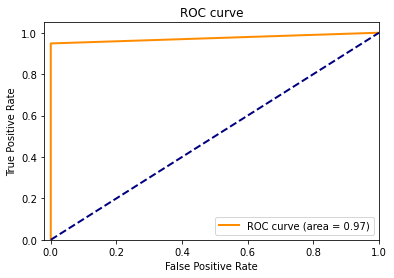

In [37]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_train[:-50000], clf.predict(X_train[:-50000]))
roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
    ############

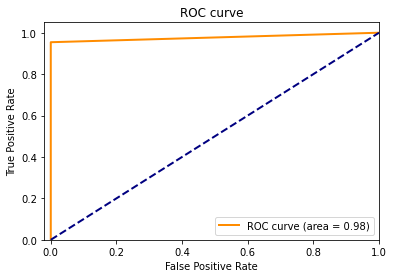

In [38]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve( y_train[-50000:],clf.predict(X_train[-50000:]))
roc_auc = auc(fpr, tpr)
    #xgb.plot_importance(gbm)
    #plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()
    ############

In [ ]:
y_test_pred.any()

In [63]:
clf.booster_.save_model('lgbm_2000_10.txt')

In [ ]:
from xgboost import plot_importance
plot_importance(model, )

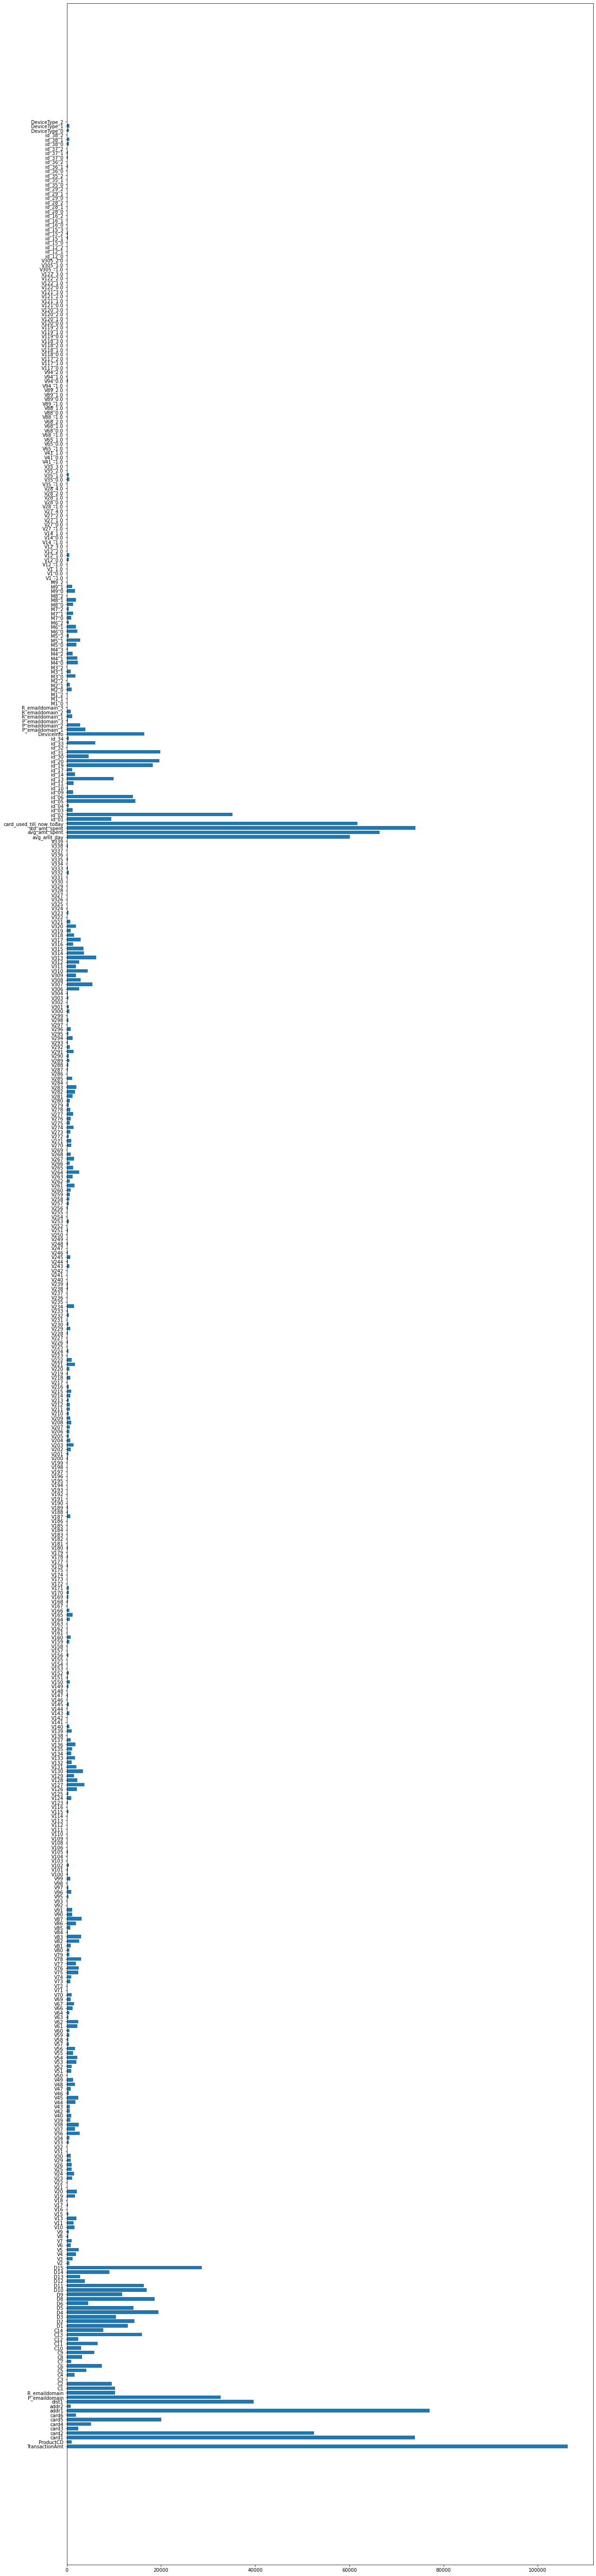

In [100]:
plt.figure(figsize=(20,100))
plt.barh(X_train.columns, clf.feature_importances_, )

plt.show()

In [45]:
X_train.columns[clf.feature_importances_.argsort()][::-1].tolist()

['TransactionAmt',
 'addr1',
 'card1',
 'std_amt_spent',
 'avg_amt_spent',
 'card_used_till_now_today',
 'card2',
 'avg_amt_day',
 'dist1',
 'id_02']

In [124]:
(clf.feature_importances_ < 5).sum()

57

In [118]:
f = X_train.columns[clf.feature_importances_.argsort()][::-1].tolist()
v = sorted(clf.feature_importances_)[::-1]

In [119]:
dict(zip(f, v))

{'TransactionAmt': 106428,
 'addr1': 77027,
 'std_amt_spent': 74023,
 'card1': 73918,
 'avg_amt_spent': 66431,
 'card_used_till_now_today': 61772,
 'avg_amt_day': 60103,
 'card2': 52560,
 'dist1': 39717,
 'id_02': 35199,
 'P_emaildomain': 32673,
 'D15': 28677,
 'card5': 20021,
 'id_31': 19884,
 'id_20': 19715,
 'D4': 19492,
 'D8': 18670,
 'id_19': 18243,
 'D10': 16986,
 'DeviceInfo': 16450,
 'D11': 16320,
 'C13': 15965,
 'id_05': 14591,
 'D2': 14384,
 'D5': 14181,
 'id_06': 14021,
 'D1': 12966,
 'D9': 11773,
 'D3': 10422,
 'C1': 10218,
 'R_emaildomain': 10215,
 'id_13': 9953,
 'C2': 9545,
 'id_01': 9500,
 'D14': 9097,
 'C14': 7709,
 'C6': 7499,
 'C11': 6599,
 'V313': 6244,
 'id_33': 6006,
 'C9': 5892,
 'V307': 5449,
 'card4': 5153,
 'id_30': 4670,
 'D6': 4554,
 'V310': 4401,
 'C5': 4198,
 'P_emaildomain_1': 3988,
 'D12': 3824,
 'V127': 3741,
 'V314': 3686,
 'V315': 3501,
 'V130': 3441,
 'C8': 3252,
 'V87': 3153,
 'V78': 3054,
 'C10': 3052,
 'V83': 3049,
 'V317': 2940,
 'V308': 2930,
 '

In [130]:
test_pred = clf.predict_proba(X_test)

In [126]:
f[-57:]

['V120_1.0',
 'V118_1.0',
 'V89_0.0',
 'V27_0.0',
 'V113',
 'M2_2',
 'V28_0.0',
 'id_15_3',
 'id_28_2',
 'V117_2.0',
 'V14_-1.0',
 'V88_0.0',
 'V14_0.0',
 'V27_2.0',
 'V27_4.0',
 'V28_-1.0',
 'V27_-1.0',
 'V27_1.0',
 'V89_-1.0',
 'V12_3.0',
 'V1_0.0',
 'V305_1.0',
 'M3_2',
 'id_29_2',
 'M1_0',
 'id_35_2',
 'V241',
 'id_36_2',
 'id_37_2',
 'id_38_2',
 'V305_2.0',
 'V122_0.0',
 'V305_-1.0',
 'V35_3.0',
 'V89_1.0',
 'V68_2.0',
 'V68_1.0',
 'V89_2.0',
 'V94_-1.0',
 'V65_0.0',
 'V94_2.0',
 'V117_0.0',
 'V41_0.0',
 'V118_0.0',
 'V118_3.0',
 'V122_3.0',
 'V119_0.0',
 'V119_1.0',
 'V119_2.0',
 'V120_0.0',
 'V120_3.0',
 'V121_0.0',
 'V28_4.0',
 'V28_2.0',
 'V121_3.0',
 'V28_1.0',
 'DeviceType_2']

In [131]:
sub = pd.DataFrame({'TransactionID': test['TransactionID'].values.tolist(),
                    'isFraud': test_pred[:,1].tolist()
                   })

sub.to_csv('submission.csv', index=False)

In [105]:
test_pred

array([[9.99999953e-01, 4.68533936e-08],
       [9.99999934e-01, 6.56395833e-08],
       [9.99999981e-01, 1.94346339e-08],
       ...,
       [9.99999784e-01, 2.16134655e-07],
       [9.99999915e-01, 8.54637925e-08],
       [9.99999434e-01, 5.65822226e-07]])

In [76]:
8.15335233e-05

8.15335233e-05

In [ ]:
import sys
np.set_printoptions(threshold=np.inf)

In [ ]:
len(X_train.columns)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
#                        model, param_grid, cv=10, scoring_fit='roc_auc',
#                        do_probabilities = False):
#     gs = RandomizedSearchCV(
#         estimator=model,
#         param_grid=param_grid, 
#         cv=2, 
#         n_jobs=6, 
#         scoring=scoring_fit,
#         verbose=20
#     )
#     fitted_model = gs.fit(X_train_data, y_train_data)
    
#     if do_probabilities:
#       pred = fitted_model.predict_proba(X_test_data)
#     else:
#       pred = fitted_model.predict(X_test_data)
    
#     return fitted_model, pred
# model = xgb.XGBClassifier()
# param_grid = {
#     'eta': [0.03],
#     'n_estimators': [3000, 5000],
#     'colsample_bytree': [0.9],
#     'max_depth': [9],
#     'reg_alpha': [0.03],
#     'reg_lambda': [0.03],
#     'subsample': [0.9],
# }

# model, pred = algorithm_pipeline(X_train[:100000], X_train[100000:110000], y_train[:100000], y_train[100000:110000], model, 
#                                  param_grid)

# # Root Mean Squared Error
# print(np.sqrt(-model.best_score_))
# print(model.best_params_)

In [2]:
clf

NameError: name 'clf' is not defined